#  GMDL 222 -  Deep Learning Practical Session 4 - Regularization
1. logsumexp 
2. Data augmentation
3. L1/L2 WeightDecay
4. Dropout



In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
from google.colab import drive
import copy
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


##  LogSumExp Trick
We might want to calculate 
$LogSumExp(x_1…x_n) = \log\big( \sum_{i=1}^{n} e^{x_i} \big)$ (i.e., cross-entropy loss of the softmax function)

In [42]:
def naive(l):
    """
    This function computes exp(l) / exp(l).sum().
    It fails if there is underflow/overflow.
     - finfo(dtype): Machine limits for floating point types. 
    """
    if (l>np.finfo(float).maxexp/2).any():        
        return "Failed: one of the terms in the numerator overflows"
    N = np.exp(l) 
    
    D = (np.exp(l).sum())
    if np.allclose(D,0):
        return "Failed: denominator is zero"
    return N/D
    

def trick(l):
    m = l.max()
    return  np.exp(l-m) / np.exp((l-m).sum())

# if you just want the denominator, you can use scipy.misc.logsumexp
# which computes things in a numerically-stable way.

l = np.array([-0.1,-0.2,-10,-100])
print('l:',l)
print('naive:',naive(l))
print('trick:',trick(l))
print()

l = np.array([-0.1,-0.2,-10,-100])-10
print('l:',l)
print('naive:',naive(l))
print('trick:',trick(l))
print()

l = np.array([-0.1,-0.2,-10,-100])-100
print('l:',l)
print('naive:',naive(l))
print('trick:',trick(l))
print()

l = np.array([-0.1,-0.2,-10,-100])+1000
print('l:',l)
print('naive:',naive(l))
print('trick:',trick(l))




l: [  -0.1   -0.2  -10.  -100. ]
naive: [5.24965360e-01 4.75008300e-01 2.63399700e-05 2.15830047e-44]
trick: [5.35751704e+47 4.84768189e+47 2.68811714e+43 2.20264658e+04]

l: [ -10.1  -10.2  -20.  -110. ]
naive: [5.24965360e-01 4.75008300e-01 2.63399700e-05 2.15830047e-44]
trick: [5.35751704e+47 4.84768189e+47 2.68811714e+43 2.20264658e+04]

l: [-100.1 -100.2 -110.  -200. ]
naive: Failed: denominator is zero
trick: [5.35751704e+47 4.84768189e+47 2.68811714e+43 2.20264658e+04]

l: [999.9 999.8 990.  900. ]
naive: Failed: one of the terms in the numerator overflows
trick: [5.35751704e+47 4.84768189e+47 2.68811714e+43 2.20264658e+04]


## Regularization - L1/L2 Norms
See [this wonderful blog post](https://sebastianraschka.com/faq/docs/regularization-linear.html) from sebastianraschka.com for more details

### L2 regularization 

In L2 regularization, we shrink the weights by computing the Euclidean norm of the weight coefficients (the weight vector w); λ is the regularization hyper-parameter.

\begin{equation}
L2: \lambda\; \lVert \mathbf{w} \lVert_2 = \lambda \sum_{j=1}^{m} w_j^2
\end{equation}
For example, we can regularize the sum of squared errors cost function (SSE) as follows:

\begin{equation}
 SSE=∑ni=(1-\lambda)\cdot(target(i)−output(i))^2+\lambda\cdot L2
 \end{equation}

Intuitively, we can think of regularization as an additional penalty term or constraint as shown in the figure below. Without regularization, our objective is to find the global cost minimum. By adding a regularization penalty, our objective becomes to minimize the cost function under the constraint that we have to stay within our “budget” (the gray-shaded ball).
![l2_image](https://docs.google.com/uc?export=download&id=1U4hM0XcbLAvbJXigiAeUzi2X-2NqtMK6)

### L1 regularization
In L1 regularization, we shrink the weights using the absolute values of the weight coefficients (the weight vector w); λ is the regularization hyper-parameter.
\begin{equation}
L1: \lambda \; \lVert\mathbf{w}\rVert_1 = \lambda \sum_{j=1}^{m} |w_j|\end{equation}

For example, we can regularize the sum of squared errors cost function (SSE) as follows:

\begin{equation}
SSE =  \sum^{n}_{i=1} \big(\text{target}^{(i)} - \text{output}^{(i)}\big)^2 + L1
\end{equation}

At its core, L1-regularization is very similar to L2 regularization. However, instead of a quadratic penalty term as in L2, we penalize the model by the absolute weight coefficients. As we can see in the figure below, our “budget” has **“sharp edges,”** which is the geometric interpretation of why the **L1 regularization induces sparsity**.

![img1](https://docs.google.com/uc?export=download&id=1yDwkLO7-jkAX8ocroTNM2KRfu6vMDcvg)


## Dropout as Regularization
Introduced in ["Dropout: A Simple Way to Prevent Neural Networks from Overfitting"](https://jmlr.org/papers/v15/srivastava14a.html).

Resources:
- [CS231 - Neural Networks Part 2](https://cs231n.github.io/neural-networks-2/#reg)
- [PyTorch - Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

"The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much". \\

With dropout, the expected output from this neuron will become $p\cdot x+(1−p)\cdot0$, because the neuron’s output will be set to zero with probability $1−p$. At test time, when we keep the neuron always active, we must adjust $x→px$ to keep the same expected output. \\
Thus, in PyTorch "the outputs are scaled by a factor of $\frac{1}{1-p}$ during training. This means that during evaluation the module simply computes an identity function."  \\

​
**Standard dropout:** 

![img1](https://docs.google.com/uc?export=download&id=1qytbGnPYoPOtwOV4twZbxN_hOBQbpik-)


Spatial dropout (image from [here](https://towardsdatascience.com/12-main-dropout-methods-mathematical-and-visual-explanation-58cdc2112293)). Grey color indicates masked pixels/featuers. Note how in the spatial dropout case, a whole channel is masked-out.

![img2](https://docs.google.com/uc?export=download&id=1kptaXcOCiLxNTuIIg1e1XQqCtCPnV6EU)



## Data Augmentation
See: https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py 


For more details on transformations available at torchvision

### Augmentations overview
 - plot some augs 
 - set torch transforms

In [43]:
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim


from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Setup

### Prepare a subset of the data

In [1]:
aug_transform = T.Compose([T.ToTensor(),
                      T.Normalize((0.5,), (0.5,)),
                      T.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1)),
                      T.RandomAffine(degrees=(-20, 20), translate=(0.01, 0.15),
                                     scale=(0.9, 1.1),fill=-1.0) 
                              ])
# no need for augmentations for our evaluation
val_transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
test_transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])

# Train on a random subset of 1000 examples
N = 1000
batch_size = 128
torch.manual_seed(0)
np.random.seed(0)

# DATA - note we use 2 train sets, baseline and aug
trainset_aug = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=aug_transform)
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=val_transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=test_transform)
train_size = len(trainset)
train_idx = np.arange(train_size)
# validaiton split
train_subset_idx = np.random.choice(train_idx, N)
train_subset_idx, val_subset_idx = train_test_split(train_subset_idx, test_size=0.2, 
                                              random_state=0)

# create samplers
train_sampler = SubsetRandomSampler(train_subset_idx)
val_sampler = SubsetRandomSampler(val_subset_idx)

NameError: ignored

In [45]:
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          sampler=val_sampler, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### Plot augmentations

In [2]:
dataiter = iter(trainloader_aug)
images, labels = dataiter.next()
dataiter_test = iter(testloader)
images_test, labels_test = dataiter_test.next()
print(images_test[0][0][0][0])
print("M images batch, 1*28*28 image size each:", images.shape)
print("M array of one-hot labels", labels.shape)



NameError: ignored

### View augmentations

Text(0.5, 1.01, 'Train set augmentations')

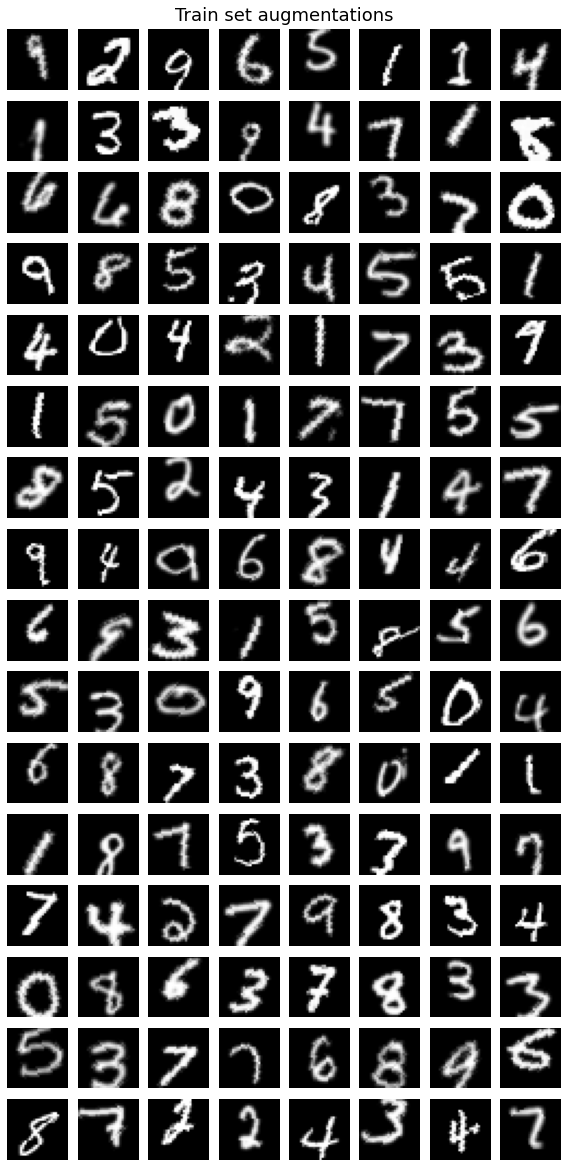

In [47]:
num_of_images = len(images)
rows = num_of_images / 8
figure = plt.figure(figsize=(8, rows))

for index in range(0, num_of_images):
    plt.subplot(rows, 8, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap="gray")
plt.tight_layout()
plt.suptitle("Train set augmentations", fontsize=18, y=1.01)

## Basic CNN model

In [48]:
class ConvNet(nn.Module):

    def __init__(self, use_dropout=False, use_dropout2d=False):
        super(ConvNet, self).__init__()

        # flags
        self.use_dropout = use_dropout
        self.use_dropout2d = use_dropout2d
        # kernel
        # Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 5, padding='same')
        self.conv2 = nn.Conv2d(64, 32, 3, padding='same')
        if self.use_dropout2d:
          self.spatial_dropout = nn.Dropout2d(p=0.2)
        # FC layers - since we use global avg pooling,
        #  input to the FC layer = #output_features of the second conv layer
        self.fc1 = nn.Linear(32, 256)
        if self.use_dropout:
          self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # adaptive_avg_pool2d with output_size=1 = simple global avg pooling
        x = self.conv2(x)
        if self.use_dropout2d:
          x = self.spatial_dropout(x)
        x =  F.relu(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        if self.use_dropout:
          x = self.dropout(x)
        x = self.fc2(x)
        return x

input_size = (1,28,28)
device = "cuda"
model = ConvNet().to(device)
model_do1d = ConvNet(use_dropout=True).to(device)
model_do2d = ConvNet(use_dropout2d=True).to(device)

print("\n########### Baseline Model ###########")
summary(model, input_size=input_size)
print("\n########### DropOut Model ###########")
summary(model_do1d, input_size=input_size)
print("\n########### Spatial DropOut Model ###########")
summary(model_do2d, input_size=input_size)


########### Baseline Model ###########
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
            Conv2d-2           [-1, 32, 14, 14]          18,464
            Linear-3                  [-1, 256]           8,448
            Linear-4                   [-1, 10]           2,570
Total params: 31,146
Trainable params: 31,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 0.12
Estimated Total Size (MB): 0.55
----------------------------------------------------------------

########### DropOut Model ###########
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
            Conv2d-2        

## Optimization and Loss 

In [49]:
softmax = nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()


In [50]:
# computes accuracy on test set for numerical labels
def eval_model(model, dataloader, device):
  correct_count, all_count = 0, 0
  model.eval()
  with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # logits
        outputs = model(inputs)
        preds_proba = softmax(outputs)
        _, preds = torch.max(preds_proba, 1)
        # eval labels here numeric (not one-hot)
        correct_pred = torch.eq(labels, preds).cpu()
        correct_count += correct_pred.numpy().sum()
        all_count += len(labels)

  print("Number Of Images Tested =", all_count)
  print("Model Accuracy =", (correct_count/all_count))
  print("---")

### Implementation of L1/L2 regularizaiton on the model's weights

In [51]:
def train_epoch(model, dataloader, criterion, optimizer, regularization=None, device="cuda"):
  model.train()
  epoch_loss = 0
  
  for i, data in enumerate(dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      # mode to device/cuda
      inputs, labels = inputs.to(device), labels.to(device)


      # zero the parameter gradients
      optimizer.zero_grad()
      logits= model(inputs)
    
      # Cross-entropy loss - input=logits
      loss = criterion(logits, labels)
      # Compute the L1/L2 norm on the model's weight and add to the loss
      if regularization == "L1":
        l1_lambda = 0.0001
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        loss = loss + l1_lambda * l1_norm
      elif regularization == "L2":
        l2_lambda = 0.0001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

      loss.backward()
      optimizer.step()
      # for visualizaiton
      epoch_loss += loss.cpu().detach().item() / len(dataloader)
  
  return epoch_loss


In [52]:
def val_epoch(model, dataloader, criterion, device="cuda"):
  epoch_loss = 0
  model.eval()   # Set model to evaluate mode
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      # mode to device/cuda
      inputs, labels = inputs.to(device), labels.to(device)
      logits= model(inputs)
      
      #pred_probab = softmax(logits)
      # Cross-entropy loss
      loss = criterion(logits, labels)
      epoch_loss += loss.cpu().detach().item() / len(dataloader)
  return epoch_loss

## Training

### Setup

In [53]:
training_dict = {"baseline": [model, trainloader],
                 "L1": [copy.deepcopy(model), trainloader],
                 "L2": [copy.deepcopy(model), trainloader],
                 "data_aug": [copy.deepcopy(model), trainloader_aug],
                 "Dropout": [model_do1d, trainloader],
                 "SpatialDropout": [model_do2d, trainloader]
}

# for loss and plotting
train_loss_dict =  {"baseline": [],
                    "L1": [],
                    "L2": [],
                 "data_aug": [],
                 "Dropout": [],
                 "SpatialDropout": []
                 }

val_loss_dict =  {"baseline": [],
                    "L1": [],
                    "L2": [],
                 "data_aug": [],
                 "Dropout": [],
                 "SpatialDropout": []
                  }

### Train all models

In [54]:
n_epochs = 200
device = "cuda"
for cond, [model_K, train_loader_K] in training_dict.items():
  print("Training:", cond)
  optimizer = optim.Adam(model_K.parameters(), lr=0.01)
  reg = cond
  #model = model.to(device)
  for epoch in tqdm(range(n_epochs)):
    train_loss = train_epoch(model_K, train_loader_K, criterion, optimizer, regularization=reg)
    val_loss = val_epoch(model_K, valloader, criterion)

    train_loss_dict[cond].append(train_loss)
    val_loss_dict[cond].append(val_loss)


Training: baseline


100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


Training: L1


100%|██████████| 200/200 [01:45<00:00,  1.89it/s]


Training: L2


100%|██████████| 200/200 [01:48<00:00,  1.85it/s]


Training: data_aug


100%|██████████| 200/200 [02:59<00:00,  1.11it/s]


Training: Dropout


100%|██████████| 200/200 [01:51<00:00,  1.79it/s]


Training: SpatialDropout


100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


### Plot results

Text(0.5, 1.0, 'Train loss')

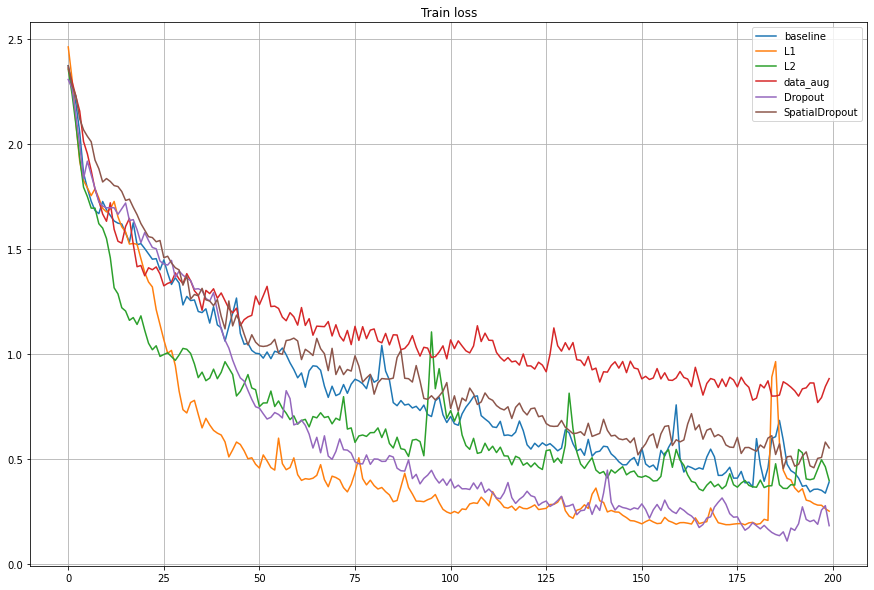

In [55]:
plt.figure(figsize=(15,10))
for cond, loss_t in train_loss_dict.items():
  plt.plot(loss_t, label=cond)

plt.legend()
plt.grid()
plt.title("Train loss")


Text(0.5, 1.0, 'Validation loss')

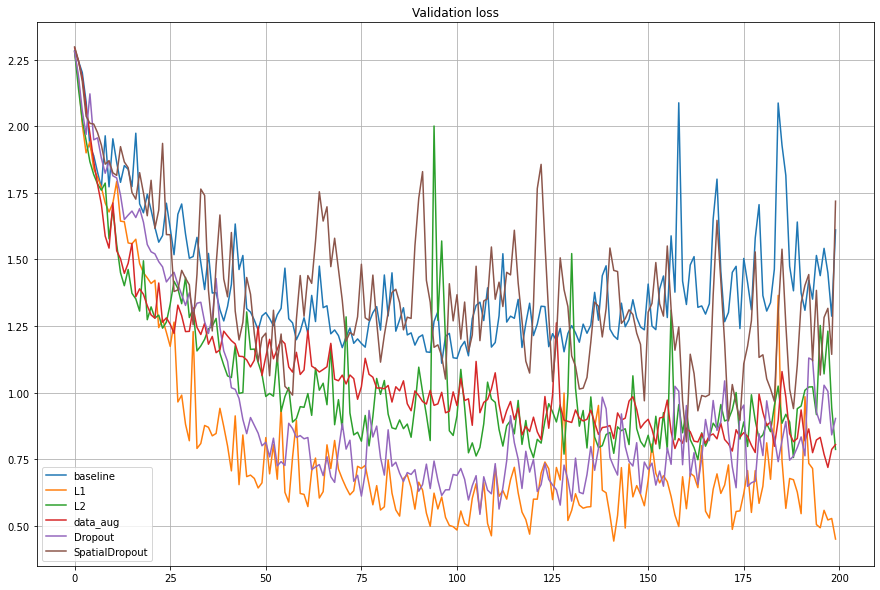

In [56]:
plt.figure(figsize=(15,10))
for cond, loss_t in val_loss_dict.items():
  plt.plot(loss_t, label=cond)

plt.legend()
plt.grid()
plt.title("Validation loss")



## Test set results

In [57]:
for cond, [model_K, train_loader_K] in training_dict.items():
  print(cond)
  eval_model(model_K, testloader, device)
  

baseline
Number Of Images Tested = 10000
Model Accuracy = 0.6293
---
L1
Number Of Images Tested = 10000
Model Accuracy = 0.9076
---
L2
Number Of Images Tested = 10000
Model Accuracy = 0.742
---
data_aug
Number Of Images Tested = 10000
Model Accuracy = 0.7426
---
Dropout
Number Of Images Tested = 10000
Model Accuracy = 0.8393
---
SpatialDropout
Number Of Images Tested = 10000
Model Accuracy = 0.5752
---
